Modèle additif, on essaie de capter la composante saisonniere avec une spline cyclique.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [2]:
def fct_scores_mse(Y_true, Y_pred, liste_stations):
    
    Y_true = Y_true.sort_values(by = ["Date"])
    Y_pred = Y_pred.sort_values(by = ["Date"])
    
    liste_mse = []
    for code in liste_stations:
        liste_mse.append(np.mean(np.square(Y_true[code] - Y_pred[code])))
    resultat = pd.DataFrame({"Code station": liste_stations, "MSE": liste_mse})
    return resultat

In [3]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

## Fonctions

### Calcul de la spline

In [4]:
def fct_Modele_Spline_fit(mesures_train, liste_stations, n_knots):
    ## Fonction pour déterminer les splines cycliques
    # mesures: dataframe X d'entrainement
    # n_knots: le nombre de noeuds
    
    mesures_stations = mesures_train[["Date"] + liste_stations]
    # On prend en abscisse le delta de temps par rapport au 01/01 de l'année en cours
    mesures_tofit = pd.DataFrame()
    liste_annee = np.unique(mesures_stations["Date"].apply(lambda x: x.year))
    for curr_annee in liste_annee:
        mesures_annee = mesures_stations[mesures_stations["Date"].apply(lambda x: x.year == curr_annee)]
        n_mesures = len(mesures_annee)
        mesures_annee.index = range(n_mesures)
        jour_an = pd.to_datetime(str(curr_annee)+"/01/01")
        jours_delta = (mesures_annee["Date"] - jour_an).apply(lambda x: x.delta)
        jours_delta.index = range(n_mesures)
        mesures_annee = pd.concat([mesures_annee, pd.DataFrame({"Delta": jours_delta})], axis = 1)
        mesures_tofit = pd.concat([mesures_tofit, mesures_annee])
    
    resultat = pd.DataFrame({"Delta": np.unique(mesures_tofit["Delta"])})
    # Calcul de la spline
    for code in liste_stations:
        X = mesures_tofit[["Delta", code]]
        spline = SplineTransformer(n_knots=curr_n_knots,
                                   extrapolation="periodic")
        model = make_pipeline(spline, LinearRegression())
        model.fit(X[["Delta"]], X[[code]])
        composante = model.predict(resultat[["Delta"]])
        composante = pd.DataFrame(composante, columns = [code])
        resultat = pd.concat([resultat, composante], axis = 1)
    return resultat

In [5]:
def fct_Modele_Spline_predict(fit, liste_dates, liste_stations):
    
    # On commence par faire les moyennes journalieres à partir du fit
    fit["Delta_Jour"] = pd.to_timedelta(fit["Delta"]).apply(lambda x: x.days)
    moyennes_fit = fit[liste_stations].groupby(fit["Delta_Jour"]).mean()
    moyennes_fit["Delta_Jour"] = moyennes_fit.index
    max_jours = np.max(moyennes_fit["Delta_Jour"])
    
    # On retourne la bonne valeur
    resultat = pd.DataFrame({"Date": liste_dates})
    liste_annees = np.unique(liste_dates.apply(lambda x: x.year))
    predictions = []
    for curr_annee in liste_annees:
        dates_annee = pd.DataFrame({"Date": liste_dates[liste_dates.apply(lambda x: x.year == curr_annee)]})
        jour_an = pd.to_datetime(str(curr_annee)+"/01/01")
        dates_annee["Delta_Jour"] = (dates_annee - jour_an)
        dates_annee["Delta_Jour"] = dates_annee["Delta_Jour"].apply(lambda x: x.days)
        for index, row in dates_annee.iterrows():
            predictions.append(moyennes_fit[moyennes_fit["Delta_Jour"] == row["Delta_Jour"]%(max_jours+1)][liste_stations].iloc[0,:])
    resultat[liste_stations] = predictions
    return resultat

# Validation croisée

In [6]:
max_n_knots = 25

for curr_n_knots in range(4, max_n_knots+1):
    print("N knots: " + str(curr_n_knots))
    cv_scores = pd.DataFrame({"Code station": liste_stations})
    for curr_split in tqdm(range(9)):
        
        # Entraintement
        curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
        curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]
    
        spline_fit = fct_Modele_Spline_fit(curr_train_X, liste_stations, curr_n_knots)
        
        # Prédictions
        curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
        curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
        liste_dates = curr_test_Y["Date"]
        
        predictions_Y = fct_Modele_Spline_predict(spline_fit, liste_dates, liste_stations)
        # Score
        curr_scores = fct_scores_mse(curr_test_Y, predictions_Y, liste_stations)
        cv_scores["Split_" + str(curr_split)] = curr_scores["MSE"]
        
    cv_moyen = []
    for code in liste_stations:
        score = np.mean(cv_scores[cv_scores["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen.append(score)    
    cv_scores["Moyenne"] = cv_moyen
    cv_scores.to_csv("../Data/Spline/cv_n_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv",
                     index=False)  

N knots: 4


100%|██████████| 9/9 [00:15<00:00,  1.78s/it]


N knots: 5


100%|██████████| 9/9 [00:16<00:00,  1.78s/it]


N knots: 6


100%|██████████| 9/9 [00:16<00:00,  1.82s/it]


N knots: 7


100%|██████████| 9/9 [00:16<00:00,  1.82s/it]


N knots: 8


100%|██████████| 9/9 [00:16<00:00,  1.83s/it]


N knots: 9


100%|██████████| 9/9 [00:17<00:00,  1.91s/it]


N knots: 10


100%|██████████| 9/9 [00:17<00:00,  1.94s/it]


N knots: 11


100%|██████████| 9/9 [00:20<00:00,  2.31s/it]


N knots: 12


100%|██████████| 9/9 [00:20<00:00,  2.27s/it]


N knots: 13


100%|██████████| 9/9 [00:21<00:00,  2.34s/it]


N knots: 14


100%|██████████| 9/9 [00:21<00:00,  2.43s/it]


N knots: 15


100%|██████████| 9/9 [00:24<00:00,  2.72s/it]


N knots: 16


100%|██████████| 9/9 [00:24<00:00,  2.76s/it]


N knots: 17


100%|██████████| 9/9 [00:24<00:00,  2.76s/it]


N knots: 18


100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


N knots: 19


100%|██████████| 9/9 [00:26<00:00,  2.95s/it]


N knots: 20


100%|██████████| 9/9 [00:26<00:00,  2.99s/it]


N knots: 21


100%|██████████| 9/9 [00:26<00:00,  2.98s/it]


N knots: 22


100%|██████████| 9/9 [00:27<00:00,  3.01s/it]


N knots: 23


100%|██████████| 9/9 [00:27<00:00,  3.09s/it]


N knots: 24


100%|██████████| 9/9 [00:26<00:00,  2.99s/it]


N knots: 25


100%|██████████| 9/9 [00:28<00:00,  3.21s/it]


In [21]:
cv_moyen = pd.DataFrame()

cv_Naif = pd.read_csv("../Data/Naif/CV_scores.csv")
curr_moyen = pd.DataFrame()
for code in liste_stations:
    curr_moyen[code] = list(cv_Naif[cv_Naif["Code station"] == code]["Moyenne"])
curr_moyen["Noeuds"] = 0
cv_moyen = pd.concat([cv_moyen, curr_moyen])

for curr_n_knots in range(4, max_n_knots+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/Spline/cv_n_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Noeuds"] = curr_n_knots
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

In [22]:
n_cours_eau = 3
cours_eau = list(np.unique(stations_debit["Cours eau"]))
cours_eau_cmap = cm.get_cmap(ListedColormap(["red", "green", "blue"]))
cours_eau_couleur = pd.DataFrame({"Cours eau": cours_eau, "Index": range(n_cours_eau), "Couleur": ["red", "green", "blue"]})
cours_eau_couleur

,Cours eau,Index,Couleur
0,Garonne,0,red
1,Loire,1,green
2,Seine,2,blue


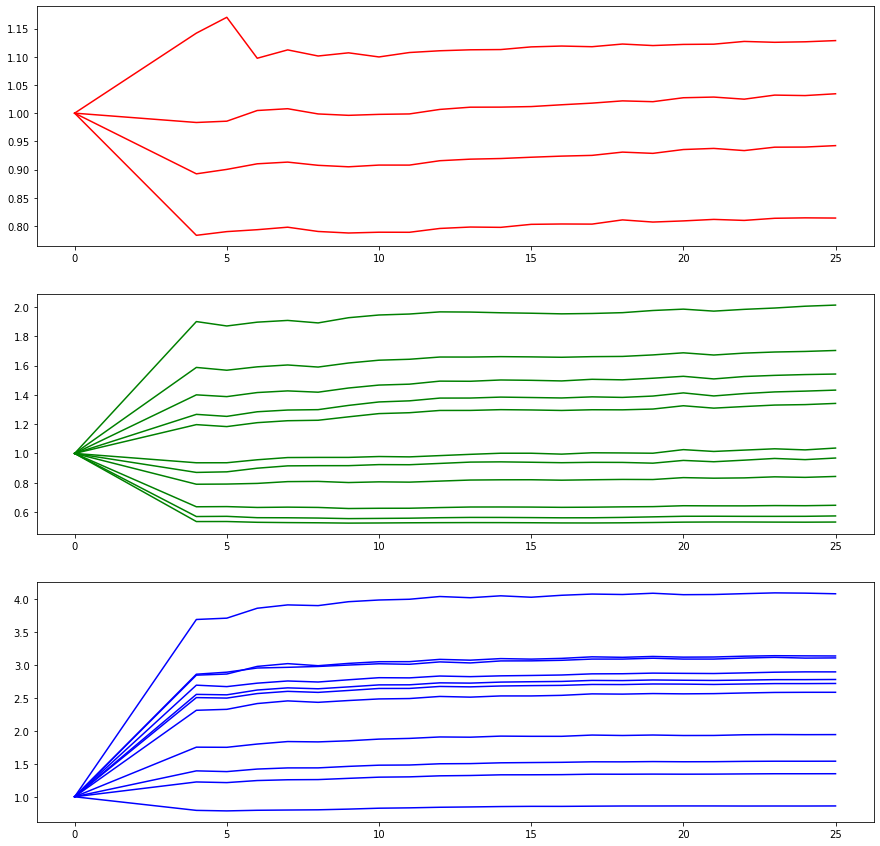

In [23]:
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,15))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Noeuds"], cv_moyen[code]/cv_moyen[code].iloc[0],
                   color = cours_eau_cmap(i))
plt.show()

# Test

In [14]:
n_knots = 4

In [15]:
liste_dates = mesures_test_Y["Date"]
spline_fit = fct_Modele_Spline_fit(mesures_test_X, liste_stations, n_knots)
predictions_test_Y = fct_Modele_Spline_predict(spline_fit, liste_dates, liste_stations)
test_scores = fct_scores_mse(mesures_test_Y, predictions_test_Y, liste_stations)

In [16]:
test_scores.to_csv("../Data/Spline/Test_scores.csv",
                   index = False)
test_scores

,Code station,MSE
0,O0200020,230.171425
1,O2620010,11007.411430
2,O6140010,33923.444338
3,O9000010,83935.657956
4,K0030020,9.891988
5,K0100020,20.635975
6,K0260020,184.309747
7,K0550010,728.450874
8,K0690010,1367.056376
9,K0910050,1345.878329


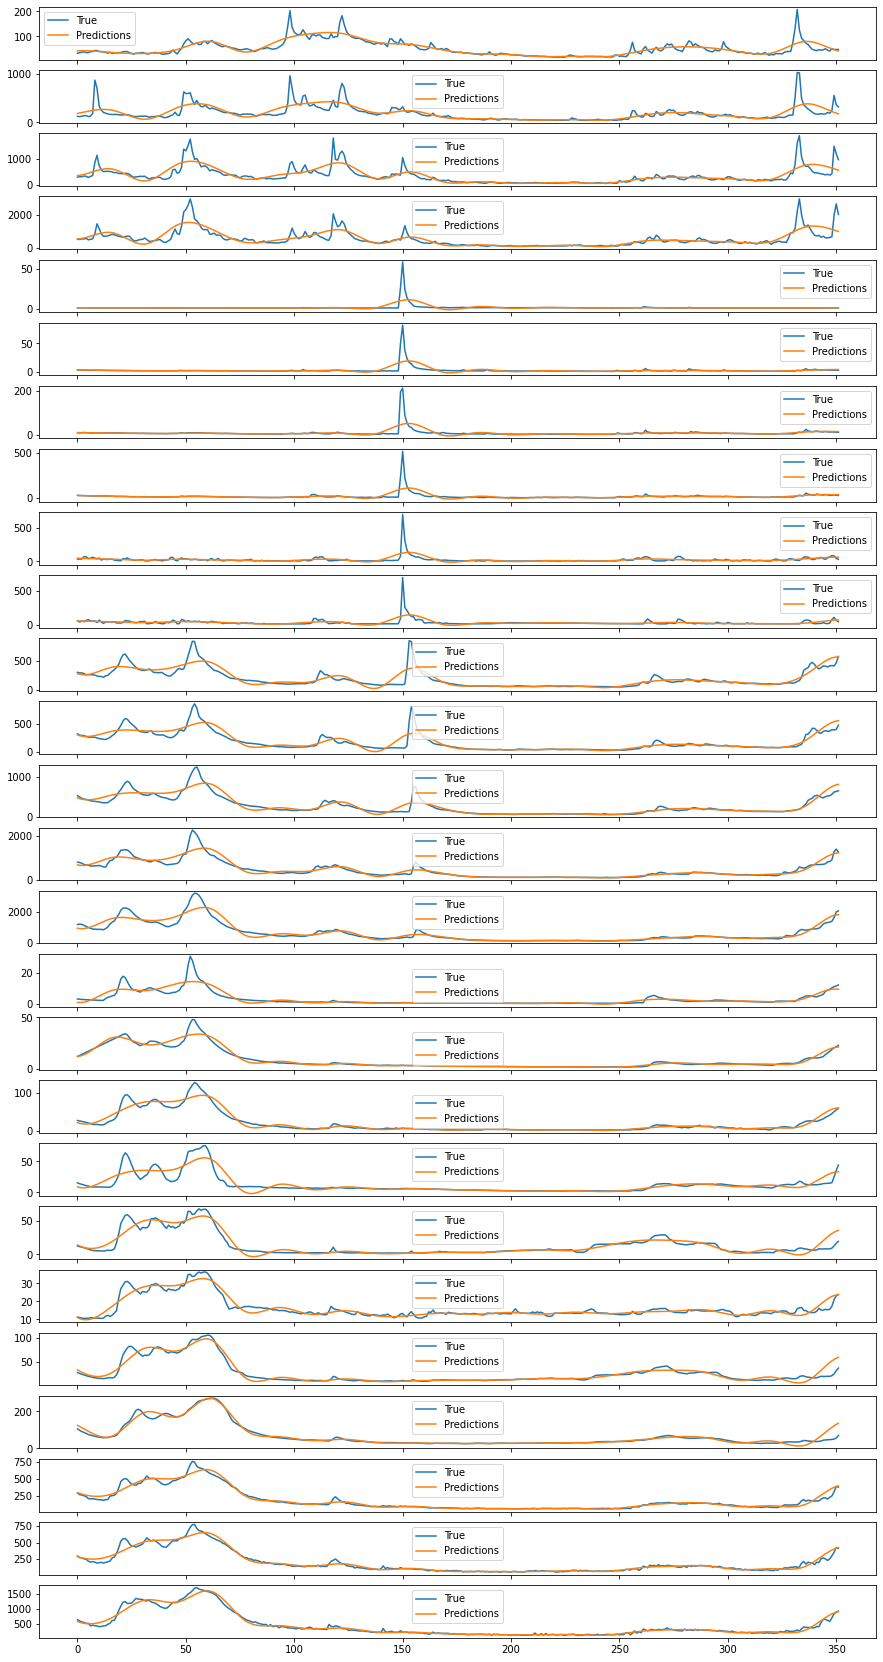

In [17]:
n_stations = len(liste_stations)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations[i]
    axs[i].plot(mesures_test_Y[code], label = "True")
    axs[i].plot(predictions_test_Y[code], label = "Predictions")
    axs[i].legend()